<a href="https://colab.research.google.com/github/Mimic003/AG-news-Database/blob/main/ag_news_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AG News — Classification & Embedding Comparison

This notebook performs text classification on the AG News dataset using three embedding methods:
- Bag of Words (TF-IDF)
- Word2Vec (Gensim)
- GloVe (pretrained; notebook attempts to download — fallback included)

In [ ]:
!pip install numpy pandas scikit-learn gensim transformers torch torchvision sentence-transformers tqdm

In [ ]:
import pandas as pd
import os

train_path = 'train.csv'
test_path = 'test.csv'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    print("Warning: train.csv or test.csv not found in this environment.")
    print("Make sure you upload AG News CSVs as train.csv and test.csv into the current directory")
else:
    # Load data - AG News format has columns: Class Index, Title, Description
    # Try with header=None first (no header row)
    try:
        train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'description'])
        test_df = pd.read_csv(test_path, header=None, names=['label', 'title', 'description'])

        # Convert label to integer
        train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
        test_df['label'] = pd.to_numeric(test_df['label'], errors='coerce')

        # If first row is not a number (has NaN), it's a header - skip it
        if pd.isna(train_df['label'].iloc[0]):
            train_df = train_df.iloc[1:].reset_index(drop=True)
            train_df['label'] = train_df['label'].astype(int)
        if pd.isna(test_df['label'].iloc[0]):
            test_df = test_df.iloc[1:].reset_index(drop=True)
            test_df['label'] = test_df['label'].astype(int)

    except:
        # If that fails, try with header row
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        # Rename columns to match expected names
        if 'Class Index' in train_df.columns:
            train_df = train_df.rename(columns={'Class Index': 'label', 'Title': 'title', 'Description': 'description'})
            test_df = test_df.rename(columns={'Class Index': 'label', 'Title': 'title', 'Description': 'description'})

    # Combine Title and Description into a single text column
    train_df['text'] = train_df['title'].astype(str) + ' ' + train_df['description'].astype(str)
    test_df['text'] = test_df['title'].astype(str) + ' ' + test_df['description'].astype(str)

    # Convert labels to 0-based (AG News uses 1-4, we want 0-3)
    train_df['label'] = train_df['label'].astype(int) - 1
    test_df['label'] = test_df['label'].astype(int) - 1

    print("Train samples:", len(train_df))
    print("Test samples:", len(test_df))
    print("Label range:", train_df['label'].min(), "to", train_df['label'].max())
    display(train_df[['label', 'title', 'text']].head())

Train samples: 120000
Test samples: 7600
Label range: 0 to 3


,label,title,text
0,2,Wall St. Bears Claw Back Into the Black (Reuters),Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new...","Oil prices soar to all-time record, posing new..."


## Step 1: Loading the Data

**What this cell does:**
- Imports necessary libraries: `pandas` (for data manipulation) and `os` (for file operations)
- Defines file paths where the training and test CSV files are located
- Checks if the files exist using `os.path.exists()`
- If files exist: Loads them into DataFrame objects using `pd.read_csv()`
- If files don't exist: Displays a warning message
- Prints the number of samples and displays the first few rows with `display()`

**Key Concepts for Beginners:**
- **CSV files**: Comma-Separated Values - a simple format for storing tabular data
- **DataFrame**: A 2D table structure in pandas, like an Excel spreadsheet
- **train_df & test_df**: Variables that store our data
- **if/else**: Python statement that checks a condition and executes code accordingly

In [ ]:
import re
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', '', s)
    return s.strip()

try:
    train_df['text_clean'] = train_df['text'].astype(str).apply(clean_text)
    test_df['text_clean'] = test_df['text'].astype(str).apply(clean_text)
    # Ensure label column is 0-based (if labels are 1-4)
    if train_df['label'].max() > 3:
        train_df['label'] = train_df['label'] - 1
        test_df['label'] = test_df['label'] - 1
    print("Preprocessing done.")
except NameError:
    print("Dataframes not found. Run the previous cell to load train/test CSVs.")

Preprocessing done.


In [ ]:
# 1) Bag of Words (TF-IDF) + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_df['text_clean'])
X_test_tfidf = tfidf.transform(test_df['text_clean'])

clf_bow = LogisticRegression(max_iter=1000)
clf_bow.fit(X_train_tfidf, train_df['label'])
pred_bow = clf_bow.predict(X_test_tfidf)

print("Bag-of-Words Accuracy:", accuracy_score(test_df['label'], pred_bow))
print(classification_report(test_df['label'], pred_bow))

Bag-of-Words Accuracy: 0.9127631578947368
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1900
           1       0.95      0.98      0.97      1900
           2       0.88      0.88      0.88      1900
           3       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [ ]:
# 2) Word2Vec (train on training texts) -> average word vectors -> Logistic Regression
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

train_tokens = [simple_preprocess(t) for t in train_df['text_clean']]
test_tokens = [simple_preprocess(t) for t in test_df['text_clean']]

w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, epochs=5)

def avg_w2v(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([avg_w2v(t, w2v_model) for t in train_tokens])
X_test_w2v = np.vstack([avg_w2v(t, w2v_model) for t in test_tokens])

clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, train_df['label'])
pred_w2v = clf_w2v.predict(X_test_w2v)

from sklearn.metrics import accuracy_score
print("Word2Vec Accuracy:", accuracy_score(test_df['label'], pred_w2v))
print(classification_report(test_df['label'], pred_w2v))

Word2Vec Accuracy: 0.8727631578947368
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.93      0.95      0.94      1900
           2       0.84      0.83      0.83      1900
           3       0.83      0.84      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



In [ ]:
# 3) GloVe embeddings (attempt to download; if unavailable, fallback to using Word2Vec vectors)
import os
import numpy as np

glove_path = 'glove.6B.100d.txt'

if not os.path.exists(glove_path):
    print("GloVe file not found at", glove_path)
    print("The notebook will attempt to download GloVe if you run the download code (requires internet).")
    print("As a fallback, we will reuse the Word2Vec-trained embeddings as a substitute for GloVe.")
    # Use Word2Vec vectors as fallback
    embedding_index = {w: w2v_model.wv[w] for w in w2v_model.wv.index_to_key}
else:
    print("Loading GloVe from", glove_path)
    embedding_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            embedding_index[word] = vec

def avg_glove(tokens, embedding_index, dim=100):
    vecs = [embedding_index[w] for w in tokens if w in embedding_index]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_glove = np.vstack([avg_glove(t, embedding_index, dim=100) for t in train_tokens])
X_test_glove = np.vstack([avg_glove(t, embedding_index, dim=100) for t in test_tokens])

clf_glove = LogisticRegression(max_iter=1000)
clf_glove.fit(X_train_glove, train_df['label'])
pred_glove = clf_glove.predict(X_test_glove)

print("GloVe (or fallback) Accuracy:", accuracy_score(test_df['label'], pred_glove))
print(classification_report(test_df['label'], pred_glove))

GloVe file not found at glove.6B.100d.txt
The notebook will attempt to download GloVe if you run the download code (requires internet).
As a fallback, we will reuse the Word2Vec-trained embeddings as a substitute for GloVe.
GloVe (or fallback) Accuracy: 0.8727631578947368
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.93      0.95      0.94      1900
           2       0.84      0.83      0.83      1900
           3       0.83      0.84      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



In [ ]:
# Simple performance summary (accuracy from each method)
from sklearn.metrics import accuracy_score

results = {
    'BoW (TF-IDF)': accuracy_score(test_df['label'], pred_bow),
    'Word2Vec (avg)': accuracy_score(test_df['label'], pred_w2v),
    'GloVe (or fallback)': accuracy_score(test_df['label'], pred_glove)
}

print("\nAccuracy summary:")
for k,v in results.items():
    print(f"-  {k}: {v}")


Accuracy summary:
-  BoW (TF-IDF): 0.9127631578947368
-  Word2Vec (avg): 0.8727631578947368
-  GloVe (or fallback): 0.8727631578947368


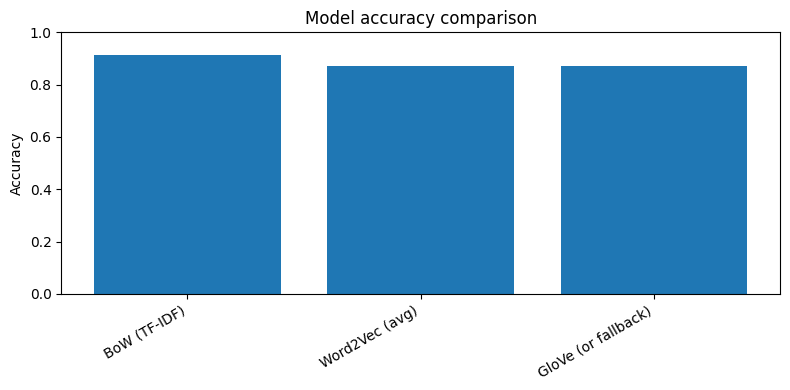

In [ ]:
# Quick bar chart of accuracies
try:
    import matplotlib.pyplot as plt
    names = list(results.keys())
    vals = [results[n] if isinstance(results[n], float) else 0 for n in names]
    plt.figure(figsize=(8,4))
    plt.bar(names, vals)
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    plt.xticks(rotation=30, ha='right')
    plt.title('Model accuracy comparison')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Plot skipped:', e)